# Topic Modeling

## Initial Setup

In [ ]:
# Installations
!pip install gensim==4.2.0
!pip install corextopic
!pip install bitermplus
!pip install tmplot

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import string
import gensim
from gensim.models import LdaModel
from gensim.models import Nmf
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from corextopic import corextopic as ct
import bitermplus as btm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Create stop words
stop_words = stopwords.words('english')
stop_words = stop_words + [
    "smoke", 
    "smoking",
    "like",
    "le",
    "im",
    "also",
    "dont"
]

In [5]:
# Constants
ALL_TEXT_COLUMNS = [
    "user_response_q1",
    "user_response_q2",
    "user_response_q3",
    "user_response_q4",
    "user_response_q5",
    "bot_reflection1",
    "bot_reflection2",
    "bot_reflection3",
    "bot_reflection4",
    "bot_reflection5",
    "user_feedback1",
    "user_feedback2",
    "user_feedback3",
    "user_feedback4",
    "user_feedback5",
]

# Questions in the conversation
QUESTION_1 = 'BOT: To start, what is the thing you like most about smoking?'
QUESTION_2 = 'BOT: Now, what is the thing you like least about smoking?'
QUESTION_3 = 'BOT: Now, what is one thing about your smoking habit that you would like to change?'
QUESTION_4 = 'BOT: What will it look like when you have made this change in your smoking habit?'
QUESTION_5 = 'BOT: Finally, what are the steps you need to take to make this change?'

In [ ]:
# Read data
df = pd.read_csv("filepath to data here")
df.head(2)

## Preprocessing

In [7]:
# Store the original unclean user responses to look at later
df["user_q_responses_orig"] = df["user_response_q1"] \
  + ". " + df["user_response_q2"] \
  + ". " + df["user_response_q3"] \
  + ". " + df["user_response_q4"] \
  + ". " + df["user_response_q5"]

In [8]:
lemmatizer = WordNetLemmatizer()
# Function to lemmatize and remove stop words
def lemmatize_text(text):
  return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

In [9]:
# Function to clean a series of text
def clean_text(series):
  # Make sure it is type str
  tmp = series.astype(str)

  # Remove punctuation
  tmp = tmp.map(lambda x: x.translate(str.maketrans('','', string.punctuation)))

  # Make lowercase
  tmp = tmp.map(lambda x: x.lower())

  # Lemmatize the series
  tmp = tmp.map(lemmatize_text)

  return tmp

In [10]:
# Clean all of our text columns
for col in ALL_TEXT_COLUMNS:
  df[col] = clean_text(df[col])

df.head(2)

,id,user_response_q1,user_response_q2,user_response_q3,user_response_q4,user_response_q5,bot_reflection1,bot_reflection2,bot_reflection3,bot_reflection4,...,care3num,care4num,care5num,care6num,care7num,care8num,care9num,care10num,convo,user_q_responses_orig
0,0,nikotine,smell,would stop,decrease quit evntually,stop buying cigarette,enjoy nicotine cigarette give pleasure,dislike way make house smell,want quit,want see change life achieved,...,4,5,5,5,5,5,5,5,"BOT: Hello! My name is MIBot, I am a computer...",the nikotine. the smell. i would like to stop....
1,1,fact action usually take place taking break wo...,smell tip finger yellowish smile antisocial pa...,would love decrease number cigarette per day,think would much happy person beginning course...,find substitute habit interchange,youre enjoying social aspect,dislike feeling alone social stigma come,want reduce amount cigarette,trying improve mental health,...,5,2,4,4,5,4,5,4,"BOT: Hello! My name is MIBot, I am a computer...",The fact that the action usually takes place w...


In [11]:
# Combine all the user text into one column
df["user_text"] = df["user_response_q1"] \
  + ". " + df["user_response_q2"] \
  + ". " + df["user_response_q3"] \
  + ". " + df["user_response_q4"] \
  + ". " + df["user_response_q5"] \
  + ". " + df["user_feedback1"] \
  + ". " + df["user_feedback2"] \
  + ". " + df["user_feedback3"] \
  + ". " + df["user_feedback4"] \
  + ". " + df["user_feedback5"]

# Create all user question responses column
df["user_q_responses"] = df["user_response_q1"] \
  + ". " + df["user_response_q2"] \
  + ". " + df["user_response_q3"] \
  + ". " + df["user_response_q4"] \
  + ". " + df["user_response_q5"]

# Create all user feedback column
df["user_feedback"] = df["user_feedback1"] \
  + ". " + df["user_feedback2"] \
  + ". " + df["user_feedback3"] \
  + ". " + df["user_feedback4"] \
  + ". " + df["user_feedback5"]

In [12]:
# Declare our corpus
corpus = df["user_q_responses"]

## Jaccard Distance Functions

In [13]:
# Calculate the jaccard distance between two sets
def calc_jaccard(set1: set, set2: set):
  if len(set1) == 0 or len(set2) == 0: return 0
  return float(len(set1.intersection(set2))) / len(set1.union(set2))

In [14]:
# Calculate a jaccard distance metric for a topic model
def calc_jaccard_topic_distance(topic_terms):
  # Convert list of terms to set of terms
  topic_term_sets = [set(terms) for terms in topic_terms]

  # For each topic, calc jaccard distance to every other topic
  jaccard_list = []
  for term_set in topic_term_sets:
    jaccard_distances = []
    for other_term_set in topic_term_sets:
      jaccard_distances.append(calc_jaccard(term_set, other_term_set))

    # Take the mean of jaccard distances
    mean_jaccard_dist = np.mean(jaccard_distances)
    jaccard_list.append(mean_jaccard_dist)
  
  # Return the mean of all the topic jaccard distances
  return np.mean(jaccard_list)

## Latent Dirichlet Allocation (LDA)

In [15]:
# Function to run LDA
def run_lda(series, num_topics, topn=20):
  # Split documents into a list of words
  split_text = series.apply(simple_preprocess).tolist()
  
  # Remove the words that are not in our stop words
  split_text = [[word for word in doc if word not in stop_words] for doc in split_text]

  # Create our id to token count dictionary
  dictionary = corpora.Dictionary(split_text)

  # Create our corpus
  corpus = [dictionary.doc2bow(text) for text in split_text]  

  # Train our LDA model
  lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

  # Get all our topics
  topic_terms = []
  for i in range(0, num_topics):
    terms = lda_model.get_topic_terms(i, topn=topn)
    topic_terms.append([term[0] for term in terms])

  return lda_model, corpus, dictionary, topic_terms

In [ ]:
# Create lists to store metrics
num_topic_list = []
perplexity_list = []
coherence_list = []
jaccard_list = []

# Calculate metric for LDA for num of topic 2 to 50
for i in range(2, 50):
  # Run the LDA model
  lda_model, lda_corpus, lda_dictionary, lda_topic_terms = run_lda(corpus, num_topics=i)
  
  # Store num_topics
  num_topic_list.append(i)
  
  # Store perplexity
  perplexity_list.append(lda_model.log_perplexity(lda_corpus))

  # Store coherence
  coherence_model = CoherenceModel(model=lda_model, corpus=lda_corpus, coherence="u_mass")
  coherence_list.append(coherence_model.get_coherence())

  # Store jaccard distance
  jaccard = calc_jaccard_topic_distance(lda_topic_terms)
  jaccard_list.append(jaccard)

# Construct our result DataFrame
lda_result_df = pd.DataFrame({
    "num_topics": num_topic_list,
    "perplexity": perplexity_list,
    "coherence": coherence_list,
    "jaccard": jaccard_list,
    "model": "LDA"
})

In [17]:
# View our results
lda_result_df.head()

,num_topics,perplexity,coherence,jaccard,model
0,2,-6.331088,-2.527951,0.740741,LDA
1,3,-6.455265,-3.092680,0.608101,LDA
2,4,-6.586663,-3.212071,0.552956,LDA
3,5,-6.620855,-4.556320,0.435877,LDA
4,6,-6.679942,-5.520883,0.390469,LDA


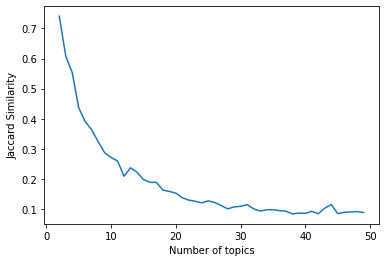

In [18]:
# Lineplot of number of topics against jaccard
ax = sns.lineplot(data=lda_result_df, x="num_topics", y="jaccard")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Jaccard Similarity")
plt.show()

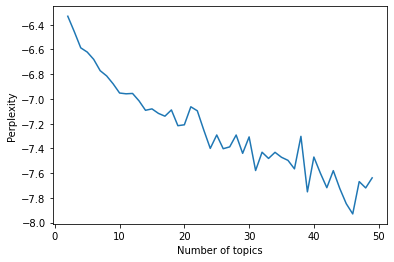

In [19]:
# Lineplot of number of topics against perplexity
ax = sns.lineplot(data=lda_result_df, x="num_topics", y="perplexity")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Perplexity")
plt.show()

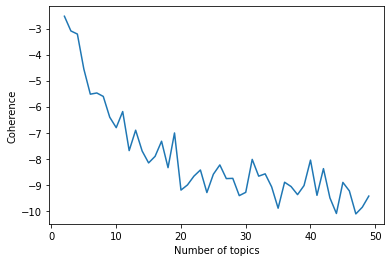

In [20]:
# Lineplot of number of topics against coherence
ax = sns.lineplot(data=lda_result_df, x="num_topics", y="coherence")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.show()

In [21]:
# Run lda on 6 topics
lda_model, lda_corpus, lda_dictionary, lda_topic_terms = run_lda(corpus, num_topics=6, topn=10)
lda_topic_words = [[lda_dictionary[word_idx] for word_idx in doc] for doc in lda_topic_terms]
pd.DataFrame(lda_topic_words).T

,0,1,2,3,4,5
0,stop,would,feel,want,change,feel
1,smell,stop,make,stop,nothing,smell
2,cigarette,feel,smell,ill,stop,stop
3,would,get,cigarette,change,tobacco,health
4,maybe,health,stop,smell,smell,need
5,calm,quit,think,cigarette,find,feeling
6,money,reduce,would,health,think,make
7,buying,need,health,anxiety,would,way
8,better,something,get,get,sensation,life
9,help,social,know,go,vape,habit


In [22]:
# Print comma seperated topics
[", ".join(topic) for topic in lda_topic_words]

['stop, smell, cigarette, would, maybe, calm, money, buying, better, help',
 'would, stop, feel, get, health, quit, reduce, need, something, social',
 'feel, make, smell, cigarette, stop, think, would, health, get, know',
 'want, stop, ill, change, smell, cigarette, health, anxiety, get, go',
 'change, nothing, stop, tobacco, smell, find, think, would, sensation, vape',
 'feel, smell, stop, health, need, feeling, make, way, life, habit']

## Non-negative Matrix Factorization (NMF)

In [23]:
# Function to run NMF
def run_nmf(series, num_topics, topn=20):
  # Split documents into a list of words
  split_text = series.apply(simple_preprocess).tolist()
  
  # Remove the words that are not in our stop words
  split_text = [[word for word in doc if word not in stop_words] for doc in split_text]

  # Create our id to token count dictionary
  dictionary = corpora.Dictionary(split_text)

  # Create our corpus
  corpus = [dictionary.doc2bow(text) for text in split_text]  

  # Train our NMF model
  model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics)

  # Get all our topics
  topic_terms = []
  for i in range(0, num_topics):
    terms = model.get_topic_terms(i, topn=topn)
    topic_terms.append([term[0] for term in terms])

  return model, corpus, dictionary, topic_terms

In [24]:
# Lists to store our results
num_topics_list = []
coherence_list = []
jaccard_list = []

# Calculate metrics from 2 to 50 number of topics
for i in range(2, 51):
  # Run NMF
  nmf_model, nmf_corpus, nmf_dictionary, nmf_topic_terms = run_nmf(corpus, num_topics=i)

  # Store number of topics
  num_topics_list.append(i)

  # Store coherence
  coherence_model = CoherenceModel(model=nmf_model, corpus=nmf_corpus, coherence="u_mass")
  coherence_list.append(coherence_model.get_coherence())

  # Calculate jaccard
  jaccard = calc_jaccard_topic_distance(nmf_topic_terms)
  jaccard_list.append(jaccard)

# Store our results in a DataFrame
nmf_result_df = pd.DataFrame({
    "num_topics": num_topics_list,
    "coherence": coherence_list,
    "jaccard": jaccard_list,
    "model": "NMF"
})

In [25]:
# Let's have a look
nmf_result_df.head()

,num_topics,coherence,jaccard,model
0,2,-3.475107,0.645161,NMF
1,3,-4.749453,0.444378,NMF
2,4,-5.641641,0.346586,NMF
3,5,-5.963883,0.311967,NMF
4,6,-6.974091,0.258546,NMF


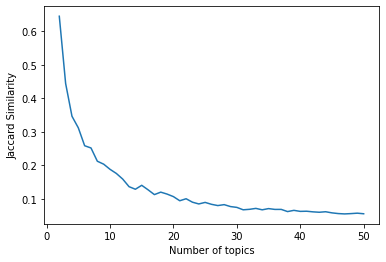

In [26]:
# Lineplot of num_topics against jaccard
ax = sns.lineplot(data=nmf_result_df, x="num_topics", y="jaccard")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Jaccard Similarity")
plt.show()

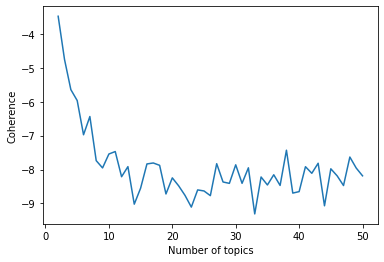

In [27]:
# Lineplot of num_topics against coherence
ax = sns.lineplot(data=nmf_result_df, x="num_topics", y="coherence")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.show()

In [28]:
# View our topic words for 4 topics
nmf_model, nmf_corpus, nmf_dictionary, nmf_topic_terms = run_nmf(df["user_q_responses"], num_topics=4, topn=10)
nmf_topic_words = [[nmf_dictionary[word_idx] for word_idx in doc] for doc in nmf_topic_terms]
pd.DataFrame(nmf_topic_words).T

,0,1,2,3
0,stop,better,feel,stop
1,would,make,cigarette,day
2,need,feel,health,want
3,change,social,amount,would
4,help,would,maybe,need
5,go,habit,time,cigarette
6,want,think,smell,break
7,quit,smell,way,quit
8,something,health,make,think
9,get,thing,one,ill


In [29]:
# Print comma seperated topics
[", ".join(topic) for topic in nmf_topic_words]

['stop, would, need, change, help, go, want, quit, something, get',
 'better, make, feel, social, would, habit, think, smell, health, thing',
 'feel, cigarette, health, amount, maybe, time, smell, way, make, one',
 'stop, day, want, would, need, cigarette, break, quit, think, ill']

## Biterm Topic Modeling (BTM)

In [30]:
# Function to run BTM
def run_btm(series, num_topics, topn=20):
  texts = series.tolist()
  X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
  tf = np.array(X.sum(axis=0)).ravel()
  
  # Vectorizing documents
  docs_vec = btm.get_vectorized_docs(texts, vocabulary)
  docs_lens = list(map(len, docs_vec))
  
  # Generating biterms
  biterms = btm.get_biterms(docs_vec)

  # Initialize the model
  model = btm.BTM(X, vocabulary, seed=12321, T=num_topics, M=15, alpha=50/8, beta=0.01)
  model.fit(biterms, iterations=20)
  p_zd = model.transform(docs_vec)

  # Calculate jaccard
  topic_terms = btm.get_top_topic_words(
    model,
    words_num=topn,
    topics_idx=list(range(num_topics))).T.values.tolist()

  return model, X, p_zd, topic_terms

In [ ]:
# Lists to store our metrics
num_topic_list = []
perplexity_list = []
coherence_list = []
jaccard_list = []

# Generate metrics for 2 to 50 num of topics
for i in range(2, 51):
  # Run the BTM model
  btm_model, X, p_zd, topic_terms = run_btm(corpus, num_topics=i)

  # Store number of topics
  num_topic_list.append(i)

  # Store our perplexity
  perplexity = btm_model.perplexity_
  perplexity_list.append(perplexity)
  
  # Store coherence
  coherence = btm_model.coherence_
  coherence_list.append(np.mean(coherence))

  # Calculate jaccard
  jaccard = calc_jaccard_topic_distance(topic_terms)
  jaccard_list.append(jaccard)

# Store results in DataFrame
btm_result_df = pd.DataFrame({
    "num_topics": num_topic_list,
    "perplexity": perplexity_list,
    "coherence": coherence_list,
    "jaccard": jaccard_list,
    "model": "BTM"
})

In [32]:
# Let's have a look
btm_result_df.head()

,num_topics,perplexity,coherence,jaccard,model
0,2,395.946741,-145.664388,0.740741,BTM
1,3,346.606022,-152.673775,0.527479,BTM
2,4,301.153367,-157.104059,0.420319,BTM
3,5,290.301022,-155.946376,0.385383,BTM
4,6,255.883328,-152.563271,0.318869,BTM


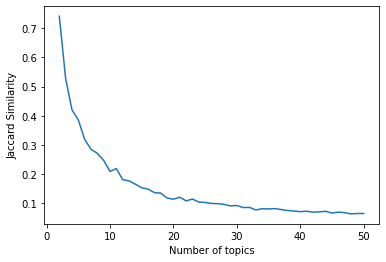

In [33]:
# Plot number of topics against jaccard
ax = sns.lineplot(data=btm_result_df, x="num_topics", y="jaccard")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Jaccard Similarity")
plt.show()

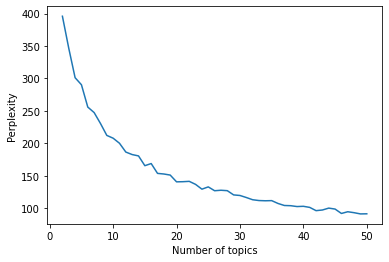

In [34]:
# Lineplot of number of topics against perplexity
ax = sns.lineplot(data=btm_result_df, x="num_topics", y="perplexity")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Perplexity")
plt.show()

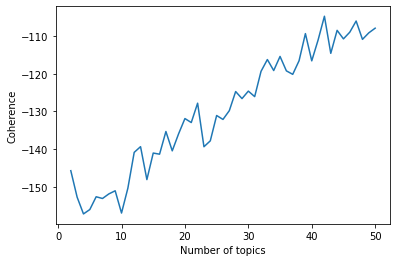

In [35]:
# Plot number of topics against coherence
ax = sns.lineplot(data=btm_result_df, x="num_topics", y="coherence")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.show()

In [36]:
# Get our topic words on 4 topics
btm_model, X, p_zd, btm_topic_terms = run_btm(corpus, num_topics=4, topn=10)
pd.DataFrame(btm_topic_terms).T

100%|██████████| 97/97 [00:00<00:00, 63959.67it/s]


,0,1,2,3
0,would,stop,make,want
1,stop,feel,need,feel
2,cigarette,le,health,time
3,money,way,stop,ill
4,feel,make,would,le
5,think,smell,social,get
6,amount,want,feel,maybe
7,day,think,id,smell
8,health,would,think,stop
9,time,time,something,help


In [37]:
# Display our topic terms in a comma seperated list
[", ".join(topic) for topic in btm_topic_terms]

['would, stop, cigarette, money, feel, think, amount, day, health, time',
 'stop, feel, le, way, make, smell, want, think, would, time',
 'make, need, health, stop, would, social, feel, id, think, something',
 'want, feel, time, ill, le, get, maybe, smell, stop, help']

## CoreEx

In [38]:
# Function to run CoreEx
def run_corex(series, num_topics, anchors=None):
  # TF-IDF Vectorizer
  vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range = (1,1))
  tf_idf = vectorizer.fit_transform(series)

  # Get feature names
  feature_names = vectorizer.get_feature_names_out()

  # Initilize our Corex model
  corex_model = ct.Corex(n_hidden=num_topics)

  # Fit our model
  corex_model.fit(tf_idf, words=feature_names, anchors=anchors)

  # View our topics
  topic_terms = []
  for topic in corex_model.get_topics():
    words = [x[0] for x in topic]
    topic_terms.append(words)
  
  return topic_terms

In [39]:
# Define our anchor words
ANCHORS = [
    # Finance
    ["price", "expensive", "cost", "money", "buy", "buying", "monetary"],
    # Calming
    ["feeling", "feel", "calm", "calming", "relax", "relaxation", "break", "meditative", "peace"],
    # Health
    ["health", "healthy", "healthier", "cancer", "ill", "exercising", "exercise", "breathe", "breathing", "coughing", "dying"]
]

In [40]:
# Lists to store our metrics
num_topic_list = []
jaccard_list = []

# Generate our metrics for number of topics 3 to 20
# NOTE: For some reason code breaks if we pass 20 topics
for i in range(3, 50):
  # Print our progress
  if i % 5 == 0: print("{}/50 complete".format(i))

  # Run the BTM model
  topic_terms = run_corex(df["user_q_responses"], num_topics=i, anchors=ANCHORS)
  
  # Store num topics
  num_topic_list.append(i)

  # Calculate jaccard
  jaccard = calc_jaccard_topic_distance(topic_terms)
  jaccard_list.append(jaccard)

# Store our results in a DataFrame
coreex_result_df = pd.DataFrame({
    "num_topics": num_topic_list,
    "jaccard": jaccard_list,
    "model": "CoreEx"
})

5/50 complete
10/50 complete
15/50 complete
20/50 complete
25/50 complete
30/50 complete
35/50 complete
40/50 complete
45/50 complete


In [41]:
# View our results
coreex_result_df.head()

,num_topics,jaccard,model
0,3,0.333333,CoreEx
1,4,0.250000,CoreEx
2,5,0.200000,CoreEx
3,6,0.166667,CoreEx
4,7,0.142857,CoreEx


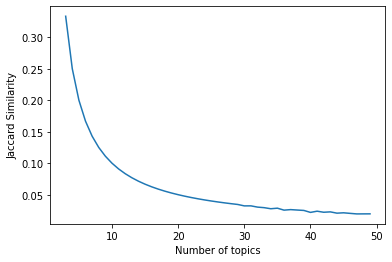

In [42]:
# Plot number of topics against jaccard
ax = sns.lineplot(data=coreex_result_df, x="num_topics", y="jaccard")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Jaccard Similarity")
plt.show()

### CoreEx with 6 topics

In [43]:
# We have 3 anchor topics, lets have 3 more topics for a total of 6 topics
NUM_TOPICS = 6

In [44]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range = (1,1))
tf_idf = vectorizer.fit_transform(df["user_q_responses"])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Initilize our Corex model
corex_model = ct.Corex(n_hidden=NUM_TOPICS)

# Fit our model
corex_model.fit(tf_idf, words=feature_names, anchors=ANCHORS, anchor_strength=4)

# View our topics
topic_terms = []
for topic in corex_model.get_topics():
  words = [x[0] for x in topic]
  topic_terms.append(words)

In [45]:
# Lets view our topic-term matrix
pd.DataFrame(topic_terms).T

,0,1,2,3,4,5
0,price,relaxation,ill,sore,relieved,tobacco
1,buying,calming,healthier,excuse,problem,heath
2,buy,calm,healthy,change,stressed,vape
3,reducing,house,exercise,awkward,breath,filling
4,often,indoors,wish,really,wouldnt,freedom
5,disease,alone,must,number,floor,activity
6,suppose,drinking,able,go,spit,important
7,act,discipline,exhale,consume,ive,half
8,nikotine,sme,urge,kinda,mean,increase
9,evntually,guanitty,college,mindful,ready,cause


In [46]:
# Get topic documents
top_docs = corex_model.get_top_docs()
topic_documents = {}
for topic_n, topic_docs in enumerate(top_docs):
  document_ids = [x[0] for x in topic_docs]
  documents = [df.loc[id]["user_q_responses_orig"] for id in document_ids]
  topic_documents[topic_n] = documents

# View top 10 documents per topic
pd.DataFrame(topic_documents)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


,0,1,2,3,4,5
0,Chill feeling. the price. nothing. i would use...,the calming effect it has. the damage . stop s...,it destresses me. The headake and thefeel like...,The experience and also helps manage dealing w...,how it relaxes me and the feeling I get when I...,Feels good to get rid of cravings.. Expenses.....
1,it's the additional free time I get in my work...,the relaxation . the fear or cancer and health...,I think it lowers my anxiety and my stress lev...,It sort of calms me down . Occasionally having...,The relaxation it brings and how it usually me...,I feel like it reduces mu anxiety when I smoke...
2,the smoke that comes out of my mouth. the pric...,"the ritual of smoking, drinking a coffee etc.....",Relax. Smell and that it is nocive. Stop smoki...,"The taste, the whole ritual behind it, the way...","It calms me down whenever I am anxious, stress...","It's ritualistic, and helps me focus. That I h..."
3,Feeling of relaxation and just having someting...,make me less anxious. the sme;;. the guanitty....,"I don't know, I just to smoke and now I cant s...",I really like the way it makes me feel. The th...,"I've always enjoyed the ""me time"" when Im smok...","i think, i like most smoke rising from the cig..."
4,The peace that it gaves me.. To know that I ma...,Calming . The cost. Stop smoking excessively ...,this is a moment only for me. smell. I wish it...,"it helps me to stop for a bit and think, it so...",the feeling of relieved. strange taste in the ...,"take a little break, the taste of menthol. the..."
5,I just smoke in social environments. The disea...,the sense of calm that comes with it. how expe...,"It makes me think smart, concentrate and relea...","The social aspect, having a chat with people.....","its like a ritual between work breaks, after l...",calms me down. my heath . stop smooking. hopef...
6,"whole ritual that i have to get up, go out, li...",the feeling of relaxation. the smell. smoke le...,Its just a way to relax for me. The colouring ...,The peace of mind I'm feeling. It does make my...,I find it comforting; I like the smell and the...,The activity I like the most is smoking.. I sp...
7,how i feel . The scent. How regular i need it....,the sensation of calm that it gives me. that a...,"It's a nice way to kill time, also helps me de...",Arousal which comes from nicotine. The smell o...,It makes me less anxius. It is also a habit.. ...,the filling when i make smoke . the smell afte...
8,"calms anxiety. the smell, it hurts the teeth. ...",the relaxation . the smell . The amount of cig...,having something to do while im bored or while...,"The feeling of it. Also the feeling, because i...",it calms me down when im overly anxious or str...,helps with my anxiety. it cause lung cancer. s...
9,the act of smoking. the smell. nothing. Better...,Feeling of relaxation and just having someting...,the sense of relief you feel when you exhale. ...,I really dont like to smoke but Im addicted an...,Calming . The cost. Stop smoking excessively ...,Taking five minutes to smoke and relax. The sm...


## Summary

In [53]:
# Combine all of our results in one DataFrame
combined_results_df = lda_result_df \
  .append(nmf_result_df, ignore_index=True) \
  .append(btm_result_df, ignore_index=True) \
  .append(coreex_result_df, ignore_index=True)
  
combined_results_df

,num_topics,perplexity,coherence,jaccard,model
0,2,-6.331088,-2.527951,0.740741,LDA
1,3,-6.455265,-3.092680,0.608101,LDA
2,4,-6.586663,-3.212071,0.552956,LDA
3,5,-6.620855,-4.556320,0.435877,LDA
4,6,-6.679942,-5.520883,0.390469,LDA
...,...,...,...,...,...
188,45,NaN,NaN,0.021235,CoreEx
189,46,NaN,NaN,0.020321,CoreEx
190,47,NaN,NaN,0.019466,CoreEx
191,48,NaN,NaN,0.019531,CoreEx


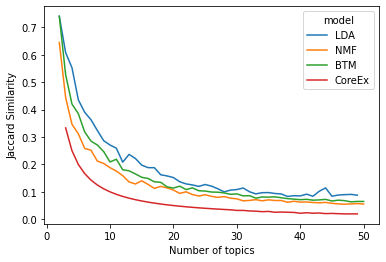

In [54]:
# Plot all of our models jaccard results
ax = sns.lineplot(data=combined_results_df, x="num_topics", y="jaccard", hue="model")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Jaccard Similarity")
plt.show()

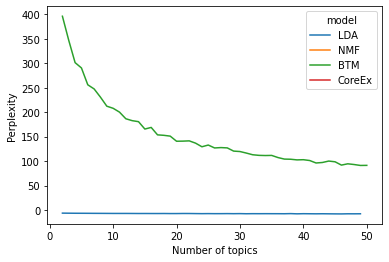

In [55]:
# Plot all of our models perplexity results
ax = sns.lineplot(data=combined_results_df, x="num_topics", y="perplexity", hue="model")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Perplexity")
plt.show()

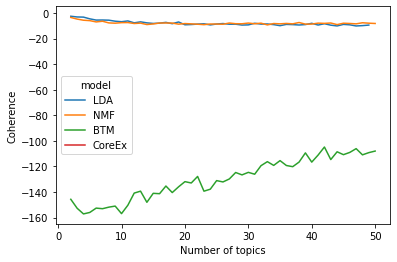

In [56]:
# Plot all of our models coherence results
ax = sns.lineplot(data=combined_results_df, x="num_topics", y="coherence", hue="model")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.show()